In [119]:
import pandas as pd

In [120]:
df = pd.read_csv('Barmenia.csv')

In [121]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,54.450001,54.450001,54.450001,54.450001,52.253620,0.0
1,2018-01-03,54.660000,54.660000,54.660000,54.660000,52.455151,0.0
2,2018-01-04,55.040001,55.040001,55.040001,55.040001,52.819824,0.0
3,2018-01-05,55.389999,55.389999,55.389999,55.389999,53.155704,0.0
4,2018-01-08,55.709999,55.709999,55.709999,55.709999,53.462795,0.0


In [122]:
df = df[['Date','Close']]

In [123]:
df.head(-5)

,Date,Close
0,2018-01-02,54.450001
1,2018-01-03,54.660000
2,2018-01-04,55.040001
3,2018-01-05,55.389999
4,2018-01-08,55.709999
...,...,...
1685,2024-08-19,71.620003
1686,2024-08-20,71.589996
1687,2024-08-21,71.730003
1688,2024-08-22,71.559998


In [124]:
import datetime

In [125]:
def str_to_datetime(s):
    split = s.split('-')
    year,month,day = int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year,month=month,day=day)

In [126]:
datetime_obejct = str_to_datetime("1986-03-19")
datetime_obejct

datetime.datetime(1986, 3, 19, 0, 0)

In [127]:
df['Date'] = df['Date'].apply(str_to_datetime)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1695 non-null   datetime64[ns]
 1   Close   1669 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.6 KB


In [129]:
df.set_index('Date',inplace = True)

In [130]:
df.head()

,Close
Date,
2018-01-02,54.450001
2018-01-03,54.660000
2018-01-04,55.040001
2018-01-05,55.389999
2018-01-08,55.709999


In [131]:
df.shape

(1695, 1)

In [132]:
import matplotlib.pyplot as plt

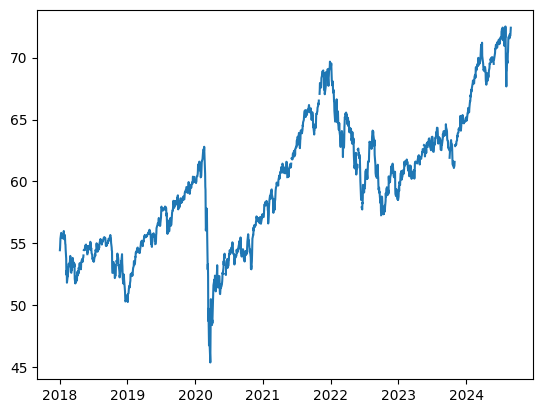

In [133]:
plt.plot(df.index,df['Close'])

In [134]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2018-01-05', 
                                '2024-08-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-01-05,54.450001,54.660000,55.040001,55.389999
1,2018-01-08,54.660000,55.040001,55.389999,55.709999
2,2018-01-09,55.040001,55.389999,55.709999,55.849998
3,2018-01-10,55.389999,55.709999,55.849998,55.730000
4,2018-01-11,55.709999,55.849998,55.730000,55.669998
...,...,...,...,...,...
1682,2024-08-19,70.470001,71.120003,71.639999,71.620003
1683,2024-08-20,71.120003,71.639999,71.620003,71.589996
1684,2024-08-21,71.639999,71.620003,71.589996,71.730003
1685,2024-08-22,71.620003,71.589996,71.730003,71.559998


In [135]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape
    

((1687,), (1687, 3, 1), (1687,))

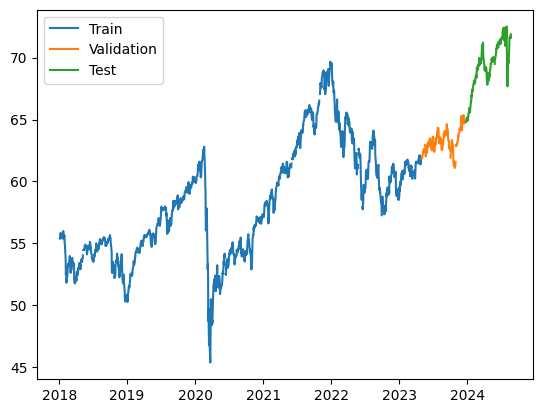

In [136]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

ValueError: object __array__ method not producing an array